In [35]:

import numpy as np
import pandas as pd
from collections import Counter
import re
import datetime
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from IPython.display import display
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics
from sklearn.model_selection import train_test_split

df_train = pd.read_csv(r'C:\Users\user\Desktop\RF_project\data_1\main_task.csv')
df_test = pd.read_csv(r'C:\Users\user\Desktop\RF_project\data_1\kaggle_task.csv')
sample_submission = pd.read_csv(r'C:\Users\user\Desktop\RF_project\data_1\sample_submission.csv')

df_test['sample'] = 0
df_train['sample'] = 1
df_test['Rating'] = 0 # в тесте нет Rating, поэтому пока проставим нулями
data_1 = df_test.append(df_train, sort=False).reset_index(drop=True)


def preprocession_data(df_input):
	
	"""Includes several fucntion to pre-process the row data"""
	
	df_output = df_input.copy()
	
	# 1. Просмотр данных
	print("Количество пропусков\n", df_output.isna().sum())
	print("Количество уникальных значений\n", df_output.nunique())
	print("Количество уникальных значений в тестовой выборке\n", df_output.nunique())
	sns.heatmap(df_output.isnull(), cmap = 'summer')
	plt.title('Диаграмма 1 Пропущенные значения по фичам')
	
	# 2. обработка Nan и пропущенных значений
	
	df_output['Cuisine Style'] = df_output['Cuisine Style'].fillna("['Others']", inplace=True)
	df_output['Price Range'] = df_output['Price Range'].fillna("['uncertain']", inplace=True)
	df_output.Reviews = df_output.Reviews.fillna('[[], []]', inplace=True)
	df_output['Number of Reviews'].fillna(df_output['Number of Reviews'].mean(), inplace = True)



	# 4. Генерация новых фитчей
	# количество ресторанов в городе
	
	df_output['main_rest'] = df_output.City.map(df_output['City'].value_counts())
	# виды кухонь
	df_output['Cuisine Style list'] = df_output['Cuisine Style'].str.findall(r"'(\b.*?\b)'")
	# относительный рейтинг
	df_output['Relative_ranking'] = df_output['Ranking']/df_output['main_rest']
	# количество отзвов в городе в городе
	reviews_city_dict = dict(df_output.groupby('City')['Number of Reviews'].sum())
	df_output['num_reviews_city'] = df_output.City.map(reviews_city_dict)
	df_output['relative_rank_reviews'] = df_output['Ranking']/df_output['num_reviews_city']

	# дамми переменная для стилей кухни
	
	# 3. Encoding - создаем dummies для городов и ценовой категории
	city_dammy = pd.get_dummies(df_output, columns = ['City'], dummy_na=True)
	price_range_dummy = pd.get_dummies(df_output, columns = ['Price Range'], dummy_na=True)
	df_output = pd.merge(df_output, city_dammy, left_index=True, right_index=True, how= 'left')
	df_output = pd.merge(df_output, price_range_dummy, left_index=True, right_index=True, how= 'left')

	# 5. Удаляем признаки с object, которые не успели обработать
	# модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
	object_columns = [s for s in df_output.columns if df_output[s].dtypes == 'object']
	df_output.drop(object_columns, axis = 1, inplace=True)
	print("Количество пропусков\n", df_output.isna().sum())
	return df_output


def ML_proc(input_data):

	output_data = input_data.copy()
	train_data = output_data.query('sample == 1').drop(['sample'], axis=1)
	test_data = output_data.query('sample == 0').drop(['sample'], axis=1)
	y = train_data.Rating.values            # наш тарге
	X = train_data.drop(['Rating'], axis=1)
	X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=47)
	model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=47)
	model.fit(X_train, y_train)

	y_pred = model.predict(X_test)
	print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
	plt.rcParams['figure.figsize'] = (10,10)
	feat_importances = pd.Series(model.feature_importances_, index=X.columns)
	feat_importances.nlargest(15).plot(kind='barh')

	return print('MAE:', metrics.mean_absolute_error(y_test, y_pred))


C:\Users\user\AppData\Local\Temp/ipykernel_5352/3063392432.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = df_test.append(df_train, sort=False).reset_index(drop=True)


Количество пропусков
 Restaurant_id            0
City                     0
Cuisine Style        11590
Ranking                  0
Price Range          17361
Number of Reviews     3200
Reviews                  2
URL_TA                   0
ID_TA                    0
sample                   0
Rating                   0
dtype: int64
Количество уникальных значений
 Restaurant_id        13094
City                    31
Cuisine Style        10731
Ranking              12975
Price Range              3
Number of Reviews     1573
Reviews              41857
URL_TA               49963
ID_TA                49963
sample                   2
Rating                  10
dtype: int64
Количество уникальных значений в тестовой выборке
 Restaurant_id        13094
City                    31
Cuisine Style        10731
Ranking              12975
Price Range              3
Number of Reviews     1573
Reviews              41857
URL_TA               49963
ID_TA                49963
sample                   2
Ratin

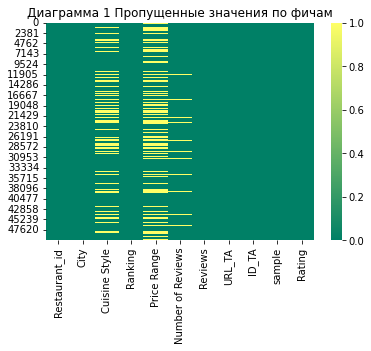

In [32]:
data_2 = preprocession_data(data_1)
print(data_2)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.3s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    0.0s finished


MAE: 0.0
MAE: 0.0


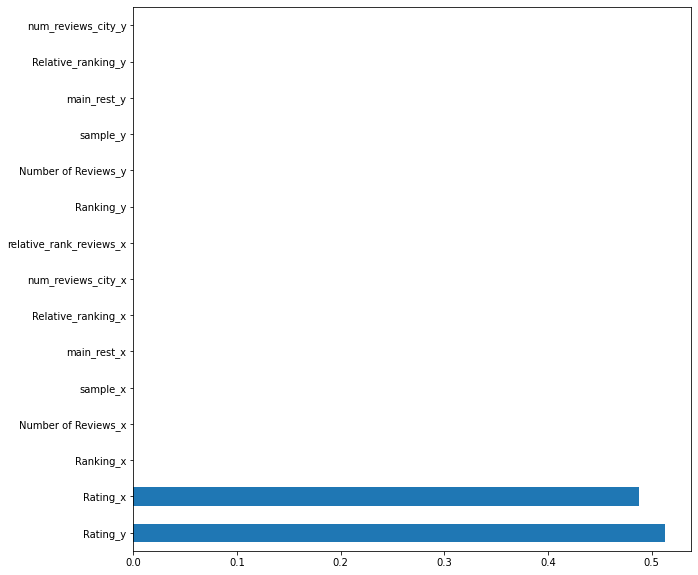

In [36]:
ML_proc(data_2)
